In [1]:
from google.colab import drive,output
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip drive/MyDrive/datasets/optic_disc/archive.zip -d archive
output.clear()

In [3]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.layers import Conv2D,Dense,Dropout,Flatten,Reshape,LeakyReLU,UpSampling2D,MaxPooling2D,concatenate,Input,Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
!pip install git+https://github.com/tensorflow/examples.git
!pip install segmentation_models

output.clear()


In [4]:
!export SM_FRAMEWORK=tf.keras
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [5]:
img_h=224
img_w=224

In [6]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))#,cmap='gray')
    plt.axis('off')
  plt.show()

In [7]:
import glob
import cv2
import os
images_t = glob.glob("archive/A.%20Segmentation/A. Segmentation/1. Original Images/a. Training Set/*.jpg")
images_t.sort()
images_v = glob.glob("archive/A.%20Segmentation/A. Segmentation/1. Original Images/b. Testing Set/*.jpg")
images_v.sort()
masks_t = glob.glob("archive/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/5. Optic Disc/*.tif")
masks_t.sort()
masks_v = glob.glob("archive/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/5. Optic Disc/*.tif")
masks_v.sort()
print(len(images_t))
print(len(images_v))
print(len(masks_t))
print(len(masks_v))

54
27
54
27


In [8]:
train_data=np.zeros((len(images_t),img_h,img_w,3),dtype=np.uint8)
test_data=np.zeros((len(images_v),img_h,img_w,3),dtype=np.uint8)
train_mask=np.zeros((len(images_t),img_h,img_w,1),dtype=bool)
test_mask=np.zeros((len(images_v),img_h,img_w,1),dtype=bool)

In [9]:
for n,id in tqdm(enumerate(images_t),total=len(images_t)):
  img=load_img(id,target_size=(224,224),color_mode='grayscale')
  img=img_to_array(img)
  train_data[n]=img

  img=load_img(masks_t[n],target_size=(224,224),color_mode='grayscale')
  img=img_to_array(img)
  train_mask[n]=img

for n,id in tqdm(enumerate(images_v),total=len(images_v)):
  img=load_img(id,target_size=(224,224),color_mode='grayscale')
  img=img_to_array(img)
  test_data[n]=img

  img=load_img(masks_v[n],target_size=(224,224),color_mode='grayscale')
  img=img_to_array(img)
  test_mask[n]=img

100%|██████████| 27/27 [00:05<00:00,  5.11it/s]


In [10]:
print(train_data.shape)
print(train_mask.shape)
print(test_data.shape)
print(test_mask.shape)

(54, 224, 224, 3)
(54, 224, 224, 1)
(27, 224, 224, 3)
(27, 224, 224, 1)


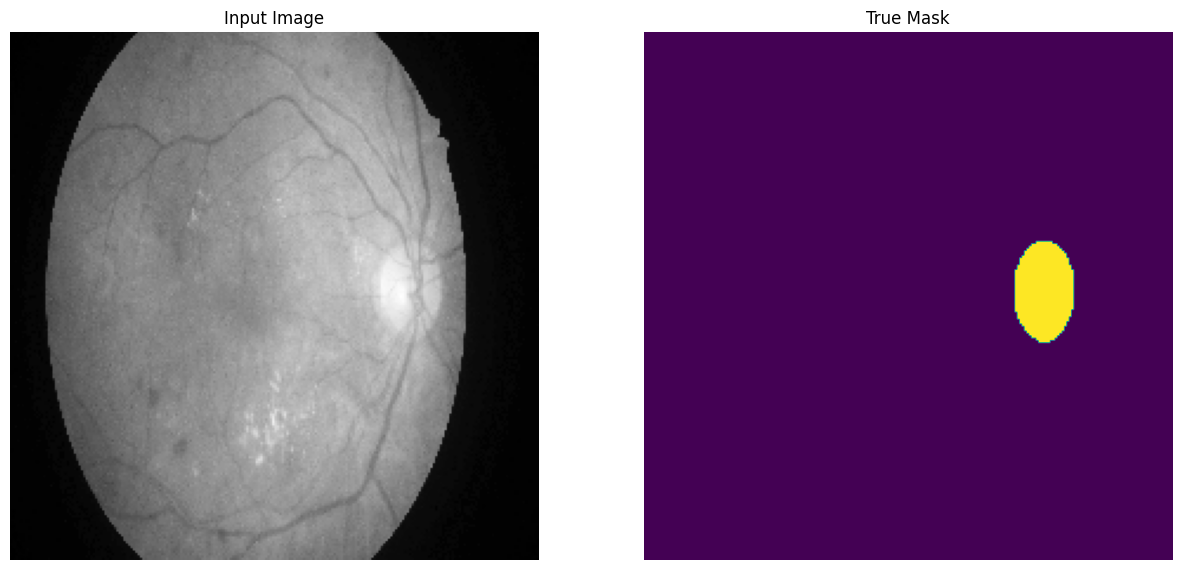

In [11]:
display([train_data[0],train_mask[0]])

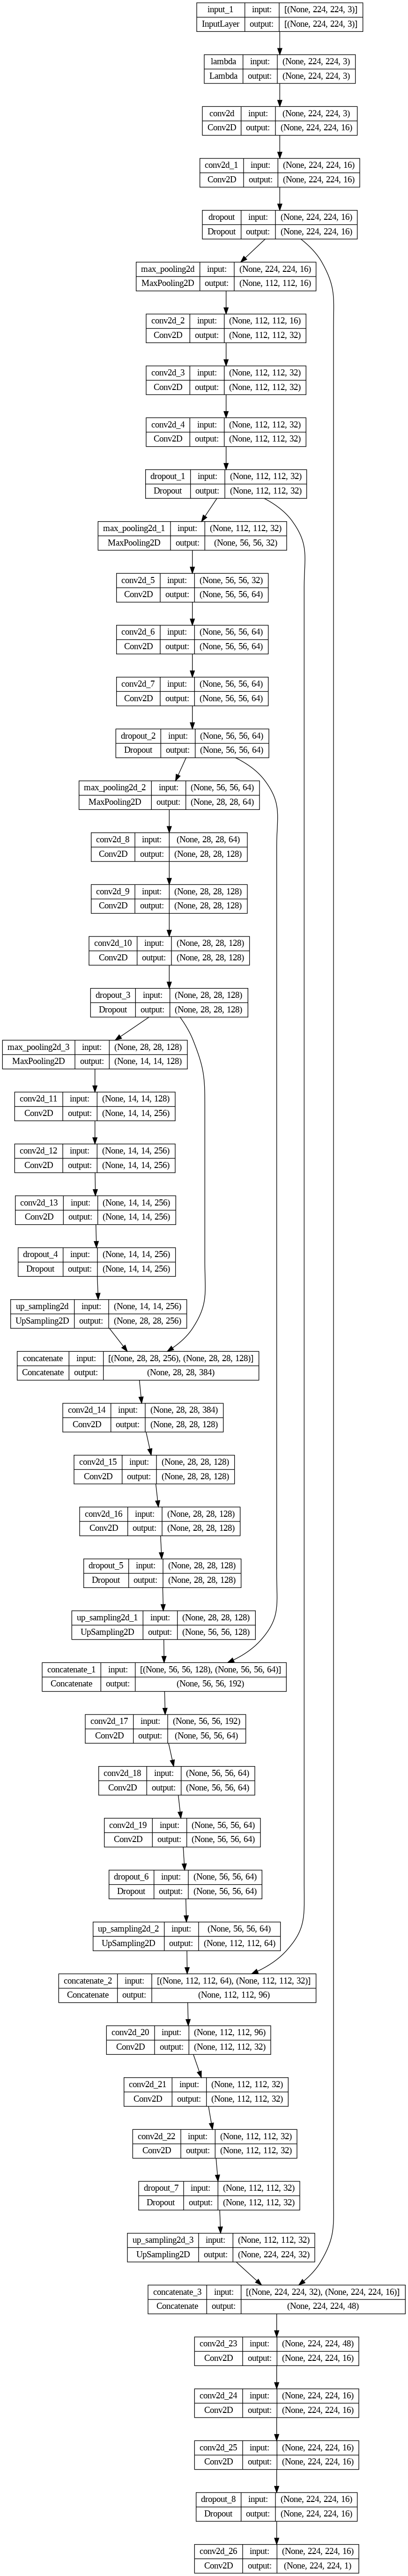

In [12]:
inputs=Input((img_h,img_w,3))
s=Lambda(lambda x:x/255)(inputs)
c1=Conv2D(16,3,padding='same',activation='relu')(s)
c1=Conv2D(16,3,padding='same',activation='relu')(c1)
c1=Dropout(0.2)(c1)
    #downsample
p1=MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(c1)

c2=Conv2D(32,3,padding='same',activation='relu')(p1)
c2=Conv2D(32,3,padding='same',activation='relu')(c2)
c2=Conv2D(32,3,padding='same',activation='relu')(c2)
c2=Dropout(0.2)(c2)
    #downsample
p2=MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(c2)

c3=Conv2D(64,3,padding='same',activation='relu')(p2)
c3=Conv2D(64,3,padding='same',activation='relu')(c3)
c3=Conv2D(64,3,padding='same',activation='relu')(c3)
c3=Dropout(0.2)(c3)
    #downsample
p3=MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(c3)

c4=Conv2D(128,3,padding='same',activation='relu')(p3)
c4=Conv2D(128,3,padding='same',activation='relu')(c4)
c4=Conv2D(128,3,padding='same',activation='relu')(c4)
c4=Dropout(0.2)(c4)
    #downsample
p4=MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(c4)

c5=Conv2D(256,3,padding='same',activation='relu')(p4)
c5=Conv2D(256,3,padding='same',activation='relu')(c5)
c5=Conv2D(256,3,padding='same',activation='relu')(c5)
c5=Dropout(0.2)(c5)

    #upsample
u6=UpSampling2D()(c5)
u6=concatenate([u6,c4])
c6=Conv2D(128,3,padding='same',activation='relu')(u6)
c6=Conv2D(128,3,padding='same',activation='relu')(c6)
c6=Conv2D(128,3,padding='same',activation='relu')(c6)
c6=Dropout(0.2)(c6)

u7=UpSampling2D()(c6)
u7=concatenate([u7,c3])
c7=Conv2D(64,3,padding='same',activation='relu')(u7)
c7=Conv2D(64,3,padding='same',activation='relu')(c7)
c7=Conv2D(64,3,padding='same',activation='relu')(c7)
c7=Dropout(0.2)(c7)

u8=UpSampling2D()(c7)
u8=concatenate([u8,c2])
c8=Conv2D(32,3,padding='same',activation='relu')(u8)
c8=Conv2D(32,3,padding='same',activation='relu')(c8)
c8=Conv2D(32,3,padding='same',activation='relu')(c8)
c8=Dropout(0.2)(c8)

u9=UpSampling2D()(c8)
u9=concatenate([u9,c1])
c9=Conv2D(16,3,padding='same',activation='relu')(u9)
c9=Conv2D(16,3,padding='same',activation='relu')(c9)
c9=Conv2D(16,3,padding='same',activation='relu')(c9)
c9=Dropout(0.2)(c9)

outputs=Conv2D(1,(1,1),activation='sigmoid')(c9)
    # Flatten(),
    # Dense(1,activation='softmax')

model=Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),loss='binary_crossentropy',metrics=['accuracy'])

# model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
mp=ModelCheckpoint('best_seg model.h5',save_best_only=True,monitor='val_accuracy')
call=[mp]

model.fit(
    train_data,
    train_mask,
    validation_data=(test_data,test_mask),
    batch_size=1,
    # steps_per_epoch=100,
    epochs=20,
    callbacks=call
)

Epoch 1/20
53/54 [============================>.] - ETA: 0s - loss: 0.3968 - accuracy: 0.8650

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/54 [==============================] - 36s 77ms/step - loss: 0.3924 - accuracy: 0.8672 - val_loss: 0.1599 - val_accuracy: 0.9827
Epoch 2/20
54/54 [==============================] - 1s 20ms/step - loss: 0.0989 - accuracy: 0.9818 - val_loss: 0.0894 - val_accuracy: 0.9827
Epoch 3/20
54/54 [==============================] - 1s 17ms/step - loss: 0.0708 - accuracy: 0.9819 - val_loss: 0.0979 - val_accuracy: 0.9827
Epoch 4/20
54/54 [==============================] - 1s 18ms/step - loss: 0.0675 - accuracy: 0.9819 - val_loss: 0.0502 - val_accuracy: 0.9827
Epoch 5/20
54/54 [==============================] - 1s 20ms/step - loss: 0.0452 - accuracy: 0.9819 - val_loss: 0.0461 - val_accuracy: 0.9827
Epoch 6/20
54/54 [==============================] - 1s 18ms/step - loss: 0.0396 - accuracy: 0.9819 - val_loss: 0.0405 - val_accuracy: 0.9827
Epoch 7/20
54/54 [==============================] - 1s 17ms/step - loss: 0.0419 - accuracy: 0.9819 - val_loss: 0.0307 - val_accuracy: 0.9827
Epoch 8/20
54/54 [=====

1/1 [==============================] - 0s 286ms/step
(1, 224, 224, 1)


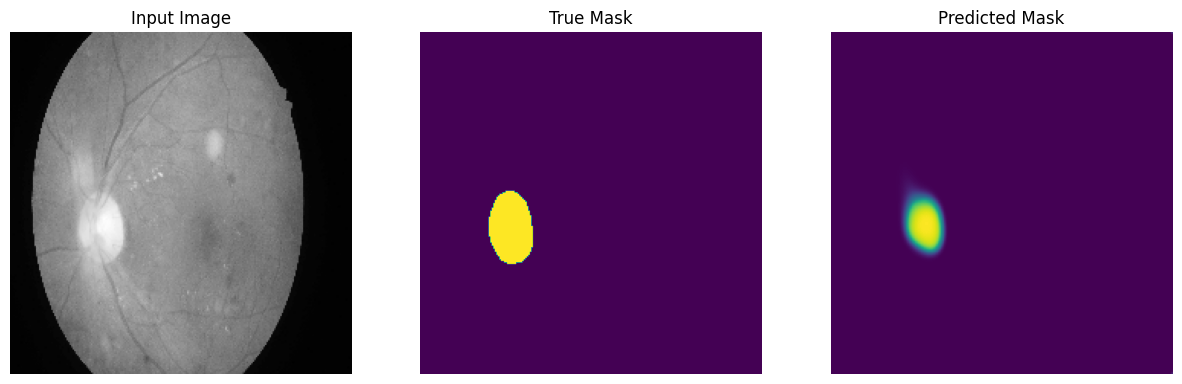

In [14]:
# for i in range(len(test_data)):
i=5
p=test_data[i]
p=p.reshape(( 1,p.shape[0], p.shape[1], p.shape[2]))
pred=model.predict(p)
  # pred=XX
print(pred.shape)
pred=pred.reshape((pred.shape[1],pred.shape[2],pred.shape[3]))
display([test_data[i],test_mask[i],pred])

In [15]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from tensorflow.keras.utils import plot_model
sm.set_framework('tf.keras')
sm.framework()
BACKBONE = 'efficientnetb4'

preprocess_input = get_preprocessing(BACKBONE)
model = Unet(BACKBONE, input_shape=(img_h,img_w,3),encoder_weights='imagenet',activation='sigmoid')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics = ['binary_accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC(),sm.metrics.IOUScore(),sm.metrics.FScore()])# tf.keras.utils.plot_model(model, show_shapes=True)

Segmentation Models: using `tf.keras` framework.
71892840/71892840 [==============================] - 1s 0us/step


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
mp=ModelCheckpoint('best_seg model.h5',save_best_only=True,monitor='val_accuracy')
call=[mp]

model.fit(
    train_data,
    train_mask,
    validation_data=(test_data,test_mask),
    batch_size=1,
    # steps_per_epoch=100,
    epochs=10,
    callbacks=call
)

Epoch 1/10
54/54 [==============================] - ETA: 0s - loss: 0.3866 - binary_accuracy: 0.9164 - recall: 0.7289 - precision: 0.1432 - auc: 0.8623 - iou_score: 0.0412 - f1-score: 0.0786

54/54 [==============================] - 93s 153ms/step - loss: 0.3866 - binary_accuracy: 0.9164 - recall: 0.7289 - precision: 0.1432 - auc: 0.8623 - iou_score: 0.0412 - f1-score: 0.0786 - val_loss: 1.6093 - val_binary_accuracy: 0.4166 - val_recall: 1.0000 - val_precision: 0.0288 - val_auc: 0.9717 - val_iou_score: 0.0283 - val_f1-score: 0.0549
Epoch 2/10
54/54 [==============================] - ETA: 0s - loss: 0.2249 - binary_accuracy: 0.9923 - recall: 0.9519 - precision: 0.7163 - auc: 0.9925 - iou_score: 0.0781 - f1-score: 0.1447

54/54 [==============================] - 6s 111ms/step - loss: 0.2249 - binary_accuracy: 0.9923 - recall: 0.9519 - precision: 0.7163 - auc: 0.9925 - iou_score: 0.0781 - f1-score: 0.1447 - val_loss: 0.5647 - val_binary_accuracy: 0.8465 - val_recall: 0.9997 - val_precision: 0.1012 - val_auc: 0.9952 - val_iou_score: 0.0469 - val_f1-score: 0.0894
Epoch 3/10
54/54 [==============================] - ETA: 0s - loss: 0.1553 - binary_accuracy: 0.9963 - recall: 0.9434 - precision: 0.8662 - auc: 0.9948 - iou_score: 0.1057 - f1-score: 0.1908

54/54 [==============================] - 5s 85ms/step - loss: 0.1553 - binary_accuracy: 0.9963 - recall: 0.9434 - precision: 0.8662 - auc: 0.9948 - iou_score: 0.1057 - f1-score: 0.1908 - val_loss: 0.3185 - val_binary_accuracy: 0.9578 - val_recall: 1.0000 - val_precision: 0.2904 - val_auc: 0.9978 - val_iou_score: 0.0709 - val_f1-score: 0.1321
Epoch 4/10
54/54 [==============================] - ETA: 0s - loss: 0.1166 - binary_accuracy: 0.9974 - recall: 0.9534 - precision: 0.9070 - auc: 0.9977 - iou_score: 0.1345 - f1-score: 0.2367

54/54 [==============================] - 5s 84ms/step - loss: 0.1166 - binary_accuracy: 0.9974 - recall: 0.9534 - precision: 0.9070 - auc: 0.9977 - iou_score: 0.1345 - f1-score: 0.2367 - val_loss: 0.1642 - val_binary_accuracy: 0.9915 - val_recall: 0.9946 - val_precision: 0.6720 - val_auc: 0.9993 - val_iou_score: 0.1079 - val_f1-score: 0.1943
Epoch 5/10
54/54 [==============================] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9980 - recall: 0.9522 - precision: 0.9400 - auc: 0.9989 - iou_score: 0.1627 - f1-score: 0.2791

54/54 [==============================] - 7s 130ms/step - loss: 0.0918 - binary_accuracy: 0.9980 - recall: 0.9522 - precision: 0.9400 - auc: 0.9989 - iou_score: 0.1627 - f1-score: 0.2791 - val_loss: 0.1110 - val_binary_accuracy: 0.9945 - val_recall: 0.9888 - val_precision: 0.7647 - val_auc: 0.9995 - val_iou_score: 0.1469 - val_f1-score: 0.2555
Epoch 6/10
54/54 [==============================] - ETA: 0s - loss: 0.0731 - binary_accuracy: 0.9983 - recall: 0.9612 - precision: 0.9478 - auc: 0.9997 - iou_score: 0.1957 - f1-score: 0.3265

54/54 [==============================] - 5s 84ms/step - loss: 0.0731 - binary_accuracy: 0.9983 - recall: 0.9612 - precision: 0.9478 - auc: 0.9997 - iou_score: 0.1957 - f1-score: 0.3265 - val_loss: 0.0790 - val_binary_accuracy: 0.9962 - val_recall: 0.9754 - val_precision: 0.8313 - val_auc: 0.9990 - val_iou_score: 0.1881 - val_f1-score: 0.3156
Epoch 7/10
54/54 [==============================] - ETA: 0s - loss: 0.0604 - binary_accuracy: 0.9985 - recall: 0.9638 - precision: 0.9529 - auc: 0.9994 - iou_score: 0.2271 - f1-score: 0.3689

54/54 [==============================] - 6s 116ms/step - loss: 0.0604 - binary_accuracy: 0.9985 - recall: 0.9638 - precision: 0.9529 - auc: 0.9994 - iou_score: 0.2271 - f1-score: 0.3689 - val_loss: 0.0619 - val_binary_accuracy: 0.9973 - val_recall: 0.9104 - val_precision: 0.9315 - val_auc: 0.9972 - val_iou_score: 0.2102 - val_f1-score: 0.3459
Epoch 8/10
54/54 [==============================] - ETA: 0s - loss: 0.0516 - binary_accuracy: 0.9985 - recall: 0.9612 - precision: 0.9579 - auc: 0.9998 - iou_score: 0.2549 - f1-score: 0.4049

54/54 [==============================] - 5s 87ms/step - loss: 0.0516 - binary_accuracy: 0.9985 - recall: 0.9612 - precision: 0.9579 - auc: 0.9998 - iou_score: 0.2549 - f1-score: 0.4049 - val_loss: 0.0534 - val_binary_accuracy: 0.9972 - val_recall: 0.9335 - val_precision: 0.9097 - val_auc: 0.9978 - val_iou_score: 0.2414 - val_f1-score: 0.3874
Epoch 9/10
54/54 [==============================] - ETA: 0s - loss: 0.0447 - binary_accuracy: 0.9985 - recall: 0.9623 - precision: 0.9573 - auc: 0.9998 - iou_score: 0.2828 - f1-score: 0.4397

54/54 [==============================] - 5s 85ms/step - loss: 0.0447 - binary_accuracy: 0.9985 - recall: 0.9623 - precision: 0.9573 - auc: 0.9998 - iou_score: 0.2828 - f1-score: 0.4397 - val_loss: 0.0460 - val_binary_accuracy: 0.9975 - val_recall: 0.9054 - val_precision: 0.9490 - val_auc: 0.9973 - val_iou_score: 0.2620 - val_f1-score: 0.4130
Epoch 10/10
54/54 [==============================] - ETA: 0s - loss: 0.0392 - binary_accuracy: 0.9988 - recall: 0.9653 - precision: 0.9661 - auc: 0.9999 - iou_score: 0.3101 - f1-score: 0.4720

54/54 [==============================] - 6s 112ms/step - loss: 0.0392 - binary_accuracy: 0.9988 - recall: 0.9653 - precision: 0.9661 - auc: 0.9999 - iou_score: 0.3101 - f1-score: 0.4720 - val_loss: 0.0409 - val_binary_accuracy: 0.9978 - val_recall: 0.9437 - val_precision: 0.9286 - val_auc: 0.9989 - val_iou_score: 0.2933 - val_f1-score: 0.4516


1/1 [==============================] - 3s 3s/step
(1, 224, 224, 1)


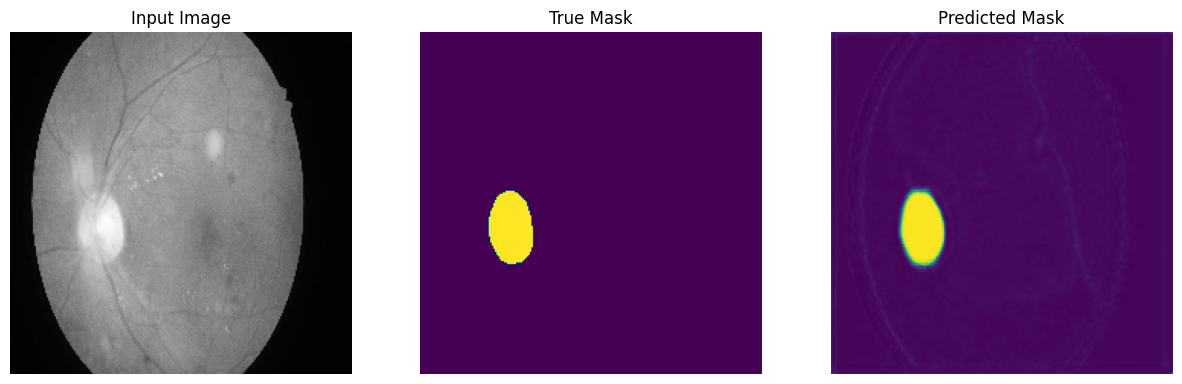

In [17]:
# for i in range(len(test_data)):
i=5
p=test_data[i]
p=p.reshape(( 1,p.shape[0], p.shape[1], p.shape[2]))
pred=model.predict(p)
  # pred=XX
print(pred.shape)
pred=pred.reshape((pred.shape[1],pred.shape[2],pred.shape[3]))
display([test_data[i],test_mask[i],pred])